In [1]:
# Jupyter version of ros_spinnaker_lsm.py for experimentation

In [2]:
import spynnaker.pyNN as pynn

from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility import Timer

from ros_spinnaker_interface import ROS_Spinnaker_Interface
# import transfer_functions as tf
from ros_spinnaker_interface import SpikeSourcePoisson
from ros_spinnaker_interface import SpikeSinkSmoothing, SpikeSinkMultipleReadoutsConvolution

import numpy as np

2017-09-10 05:58:42 INFO: Read config files: /home/roboy/.spynnaker.cfg, /usr/local/lib/python2.7/dist-packages/spynnaker/spynnaker.cfg
2017-09-10 05:58:42 INFO: topicmanager initialized


In [3]:
timer = Timer()


ts = 0.1                # simulation timestep in ms
simulation_time = 2000  # ms

pynn.setup(timestep=ts, min_delay=ts, max_delay=2.0*ts)

pynn.set_number_of_neurons_per_core('IF_curr_exp', 100)      # this will set 100 neurons per core


2017-09-10 05:58:44 INFO: sPyNNaker (c) 2016 APT Group, University of Manchester
2017-09-10 05:58:44 INFO: Release version 3.0.0() - September 2016. Installed in folder /usr/local/lib/python2.7/dist-packages
2017-09-10 05:58:44 INFO: Will search these locations for binaries: /usr/local/lib/python2.7/dist-packages/spinn_front_end_common/common_model_binaries : /usr/local/lib/python2.7/dist-packages/spynnaker_external_devices_plugin/pyNN/model_binaries : /usr/local/lib/python2.7/dist-packages/spynnaker/pyNN/model_binaries
2017-09-10 05:58:44 INFO: Setting appID to 30.
2017-09-10 05:58:44 WARNING: A timestep was entered that has forced sPyNNaker to automatically slow the simulation down from real time by a factor of 10.0. To remove this automatic behaviour, please enter a timescaleFactor value in your .spynnaker.cfg
2017-09-10 05:58:44 INFO: Setting time scale factor to 10.0.
2017-09-10 05:58:44 INFO: Setting machine time step to 100.0 micro-seconds.


# Define Neural Populations

In [15]:
############# Reservoir #################
# set up the reservoir population

n_input_neurons   = 4
n_readout_neurons = 2
n_reservoir_neurons = 59
exc_rate = 0.8 # 80% of reservoir neurons are excitatory

n_reservoir_exc = int(np.ceil(n_reservoir_neurons*exc_rate))
n_reservoir_inh = n_reservoir_neurons - n_reservoir_exc
print('Number excitatory cells: %r' % n_reservoir_exc)
print('Number inhibitory cells: %r' % n_reservoir_inh)

celltype=pynn.IF_curr_exp
cell_params ={'a': 0.02, 'c': -65.0, 'd': 2.0, 'b': 0.2, 'i_offset': 0.0}

exc_cells = pynn.Population(n_reservoir_exc, celltype, cellparams={},label="Excitatory_Cells")
inh_cells = pynn.Population(n_reservoir_inh, celltype, cellparams={},label="Inhibitory_Cells")


# initialize with a uniform random distributin
# use seeding for reproducability
rngseed = 98766987
parallel_safe = True
rng = NumpyRNG(seed=rngseed, parallel_safe=parallel_safe)

unifDistr = RandomDistribution('uniform', (-75,-65), rng=rng)
exc_cells.initialize('v',unifDistr)
inh_cells.initialize('v',unifDistr)

Number excitatory cells: 48
Number inhibitory cells: 11


# Connect the input neurons (spike source) with the reservoir

In [16]:
inp_weight=3.
inp_delay =1

inp_weight_distr = RandomDistribution('normal', [inp_weight, 1e-3], rng=rng)

# connect each input neuron to 30% of the reservoir neurons
inp_conn = pynn.FixedProbabilityConnector(p_connect=0.3,weights =inp_weight_distr, delays=inp_delay)


input_interface = ROS_Spinnaker_Interface(
        n_neurons_source=n_input_neurons,           
        Spike_Source_Class=SpikeSourcePoisson,      
                                                    
        ros_topic_send='to_spinnaker',              
       
        clk_rate=1000,                              
        ros_output_rate=10) 

connections={}
connections['inp2e'] = pynn.Projection(input_interface, exc_cells, inp_conn)
connections['inp2i'] = pynn.Projection(input_interface, inh_cells, inp_conn)


2017-09-10 06:03:55 INFO: Waiting for message to indicate that the database is ready


# Connections amongst excitatory and inhibitory populations in reservoir

In [17]:
w_exc = 20.   # later add unit
w_inh = -51.   # later add unit
delay_exc = 1      # defines how long (ms) the synapse takes for transmission
delay_inh = 1

pconn = 0.01 # sparse connection probability

weight_distr_exc = RandomDistribution('normal', [w_exc, 1e-3], rng=rng)
weight_distr_inh = RandomDistribution('normal', [w_inh, 1e-3], rng=rng)

exc_conn = pynn.FixedProbabilityConnector(pconn, weights =weight_distr_exc, delays=delay_exc)
inh_conn = pynn.FixedProbabilityConnector(pconn, weights =weight_distr_inh, delays=delay_inh)

connections['e2e'] = pynn.Projection(exc_cells, exc_cells, exc_conn)
connections['e2i'] = pynn.Projection(exc_cells, inh_cells, exc_conn)
connections['i2e'] = pynn.Projection(inh_cells, exc_cells, inh_conn)
connections['i2i'] = pynn.Projection(inh_cells, inh_cells, inh_conn)

# Readout Connections

In [18]:
rout_weight=3.
rout_delay=1

readout_neurons = pynn.Population(size=n_readout_neurons, cellclass=pynn.IF_curr_exp, cellparams={}, label='readout_neurons')

output_interface = ROS_Spinnaker_Interface(
        Spike_Sink_Class=SpikeSinkMultipleReadoutsConvolution,    
                                                    
        ros_topic_recv='from_spinnaker',            
                                    
        output_population=readout_neurons,
        clk_rate=1000,                              
        ros_output_rate=10)                         
                                                 



# here in the 'weights' you can put the list of learned weights 
rout_conn = pynn.AllToAllConnector(weights = rout_weight , delays=rout_delay)

connections['e2rout'] = pynn.Projection(exc_cells, readout_neurons, rout_conn)
connections['i2rout'] = pynn.Projection(exc_cells, readout_neurons, rout_conn)



2017-09-10 06:03:56 INFO: Waiting for message to indicate that the database is ready


# Record spikes and voltages from readout_neurons

In [19]:
readout_neurons.record()
readout_neurons.record_v()

# Run the network and measure the time it takes

In [20]:
timer.start()

pynn.run(simulation_time)

simCPUTime = timer.diff()
spikes = readout_neurons.getSpikes()

pynn.end()

2017-09-10 06:03:59 INFO: Starting execution process
2017-09-10 06:03:59 INFO: Time 0:00:00.000491 taken by FrontEndCommonApplicationGraphNetworkSpecificationReport
Partitioning graph vertices
|0                           50%                         100%|
Partitioning graph edges
|0                           50%                         100%|
2017-09-10 06:03:59 INFO: Time 0:00:00.064186 taken by PartitionAndPlacePartitioner
Generating partitioner report
|0                           50%                         100%|
2017-09-10 06:03:59 INFO: Time 0:00:00.015649 taken by PartitionerReport
Filtering edges
|0                           50%                         100%|
2017-09-10 06:03:59 INFO: Time 0:00:00.028913 taken by GraphEdgeFilter
Placing graph vertices
|0                           50%                         100%|
2017-09-10 06:03:59 INFO: Time 0:00:00.016413 taken by OneToOnePlacer
Generating placement report
|0                           50%                         100%|
Generatin

SpinnmanIOException: IO Error: [Errno 9] Bad file descriptor

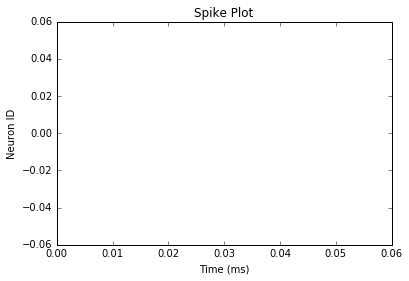

In [21]:
# Plot
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

spike_times = [spike[1] for spike in spikes]
spike_ids = [spike[0] for spike in spikes]

plt.plot(spike_times, spike_ids, ".")
plt.xlabel('Time (ms)')
plt.ylabel('Neuron ID')
plt.title('Spike Plot')
plt.xlim(xmin=0)
plt.show()

writeCPUTime = timer.diff()

In [ ]:
print "Simulation time : %g s" % simCPUTime
print "Writing time : %g s" % writeCPUTime